In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
print('numpy version',np.__version__,'\nxarray version',xr.__version__)

numpy version 1.22.4 
xarray version 2022.12.0


In [4]:
import xgcm
from xgcm import Grid
import xwmt
print('xgcm version',xgcm.__version__)
print('xwmt version',xwmt.__version__)

xgcm version 0.8.1
xwmt version 0.0.3


### Load grids and data

In [5]:
gridname = 'natv' # choose from ['zstr', 'natv', 'rho2']
dt = 'monthly' # choose from ['monthly', 'daily', 'hourly']

# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_'
time = "190*"

# Diagnostics were saved into different files
suffixs = ['surf','thck','heat','salt','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    if suffix == "surf":
        filename = prefix+suffix+'_'+time+'.nc'
    else:
        filename = prefix+gridname+'_'+suffix+'_'+time+'.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])

# Select year-long subset
ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

#  Load grid
oceangridname = '19000101.ocean_static.nc'
ocean_grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Some renaming of variables to match conventions
ocean_grid = ocean_grid.rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao', 'salt':'so'})
ds['sigma2'] = ds['rhopot2']-1000.

# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "wet": xr.DataArray(ocean_grid["wet"].values, dims=('yh', 'xh',)),
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)),
    "lon": xr.DataArray(ocean_grid["geolon"].values, dims=('yh', 'xh',)),
    "lat": xr.DataArray(ocean_grid["geolat"].values, dims=('yh', 'xh',)),
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'xh', 'right': 'xq'},
    'Y': {'center': 'yh', 'right': 'yq'},
    'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'}
}
metrics = {
    ('X','Y'): "areacello",
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=None)

### Create budget dictionary

Using `xbudget`, we can read in a pre-configured dictionary that contains comprehensive metadata about the structure of tracer budgets in MOM6. This dictionary can also be manually created.

In [6]:
import xbudget
budgets_dict = xbudget.load_preset_budget(model="MOM6")
xbudget.collect_budgets(ds, budgets_dict)
budgets_dict

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'lhs': {'var': 'mass_lhs_sum',
   'sum': {'var': 'mass_lhs_sum',
    'Eulerian_tendency': {'var': 'mass_lhs_Eulerian_tendency_product',
     'product': {'var': 'mass_lhs_Eulerian_tendency_product',
      'thickness': 'dhdt',
      'density': 1035.0}}}},
  'rhs': {'var': 'mass_rhs_sum',
   'sum': {'var': 'mass_rhs_sum',
    'advection': {'var': 'mass_rhs_advection_sum',
     'sum': {'var': 'mass_rhs_advection_sum',
      'horizontal': {'var': 'mass_rhs_advection_horizontal_product',
       'product': {'var': 'mass_rhs_advection_horizontal_product',
        'thickness': 'dynamics_h_tendency',
        'density': 1035.0}},
      'vertical': {'var': 'mass_rhs_advection_vertical_product',
       'product': {'var': 'mass_rhs_advection_vertical_product',
        'thickness': 'vert_remap_h_tendency',
        'density': 1035.0}}}},
    'surface_flux': {'var': 'wfo',
     'product': {'var': 'mass_rhs_surface_flux_product',
      'thickne

We don't need all of these terms to look at the basic water mass transformation budget, so let's use the `xbudget.aggregate` function to just pick out the high-level terms.

In [7]:
simple_budgets = xbudget.aggregate(budgets_dict)
simple_budgets

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'lhs': {'Eulerian_tendency': 'mass_lhs_Eulerian_tendency_product'},
  'rhs': {'advection': 'mass_rhs_advection_sum', 'surface_flux': 'wfo'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'opottemptend',
   'advection': 'heat_lhs_advection_product',
   'surface_flux_advective_ocean_negative_lhs': 'heat_lhs_surface_flux_advective_ocean_negative_lhs_product'},
  'rhs': {'diffusion': 'heat_rhs_diffusion_sum',
   'surface_flux': 'boundary_forcing_heat_tendency',
   'bottom_flux': 'internal_heat_heat_tendency',
   'frazil_ice': 'frazil_heat_tendency'}},
 'salt': {'lambda': 'so',
  'surface_lambda': 'sos',
  'lhs': {'Eulerian_tendency': 'osalttend',
   'advection': 'salt_lhs_advection_product',
   'surface_flux_advective_ocean_negative_lhs': 'salt_lhs_surface_flux_advective_ocean_negative_lhs_product'},
  'rhs': {'diffusion': 'salt_rhs_diffusion_sum',
   'surface_flux': 'boundary_forcing_sal

### Compute water mass transformations

Finally, we can create an instance of the core `WaterMassTransformations` class and verify that it can find all of the processes we need in the dataset.

In [8]:
wmt = xwmt.WaterMassTransformations(grid, simple_budgets)
wmt.available_processes()

['diffusion',
 'surface_flux',
 'surface_flux_advective_ocean_negative_lhs',
 'Eulerian_tendency',
 'advection',
 'frazil_ice',
 'bottom_flux']

**Note:** In addition to information about the static model grid, the attribute `grid._ds` points to the full dataset containing the diagnostics!

In [9]:
grid._ds

<xarray.Dataset>
Dimensions:                                                     (xh: 97,
                                                                 yh: 105,
                                                                 time: 12,
                                                                 nv: 2, zl: 75,
                                                                 zi: 76,
                                                                 xq: 98, yq: 106)
Coordinates:
  * xh                                                          (xh) float64 ...
  * yh                                                          (yh) float64 ...
  * time                                                        (time) object ...
  * nv                                                          (nv) float64 ...
  * zl                                                          (zl) float64 ...
  * zi                                                          (zi) float64 ...
  * xq                                                          (xq) float64 ...
  * yq                                                          (yq) float64 ...
    wet                                                         (yh, xh) float32 ...
    areacello                                                   (yh, xh) float32 ...
    lon                                                         (yh, xh) float32 ...
    lat                                                         (yh, xh) float32 ...
Data variables: (12/90)
    tos                                                         (time, yh, xh) float32 dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    sos                                                         (time, yh, xh) float32 dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    hfds                                                        (time, yh, xh) float32 dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    hflso                                                       (time, yh, xh) float32 dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    hfsso                                                       (time, yh, xh) float32 dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    rlntds                                                      (time, yh, xh) float32 dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    ...                                                          ...
    salt_rhs_surface_flux_nonadvective_exchange_sum             (time, yh, xh) float32 dask.array<chunksize=(1, 105, 97), meta=np.ndarray>
    salt_rhs_surface_flux_advective_exchange_product            (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 105, 97), meta=np.ndarray>
    salt_rhs_surface_flux_advective_ocean_negative_rhs_product  (time, yh, xh, zl) float32 dask.array<chunksize=(1, 105, 97, 75), meta=np.ndarray>
    salt_rhs_surface_flux_sum                                   (time, yh, xh, zl) float32 dask.array<chunksize=(1, 105, 97, 75), meta=np.ndarray>
    salt_rhs_sum                                                (time, zl, yh, xh) float32 dask.array<chunksize=(1, 75, 105, 97), meta=np.ndarray>
    thkcello_i                                                  (time, yh, xh, zi) float32 dask.array<chunksize=(1, 105, 97, 76), meta=np.ndarray>

We use the `integrate_transformations` method to compute area-integrated water mass transformations in the specified coordinate (e.g. `"heat"`).

In [10]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    kwargs = {"sum_components":True, "group_processes":True}
    G_temperature = wmt.integrate_transformations(
        "heat",
        bins=np.arange(-2, 30, 0.25),
        **kwargs
    ).mean('time')
    G_salinity = wmt.integrate_transformations(
        "salt",
        bins=np.arange(0, 50, 0.25),
        **kwargs
    ).mean('time')
    G_density = wmt.integrate_transformations(
        "sigma2",
        bins=np.arange(10, 40, 0.25),
        **kwargs
    ).mean('time')

Process 'frazil_ice' for component salt is unavailable.
Process 'bottom_flux' for component salt is unavailable.


Finally, we can plot the WMT associated with each of the terms and verify that our water mass transformation budgets close:

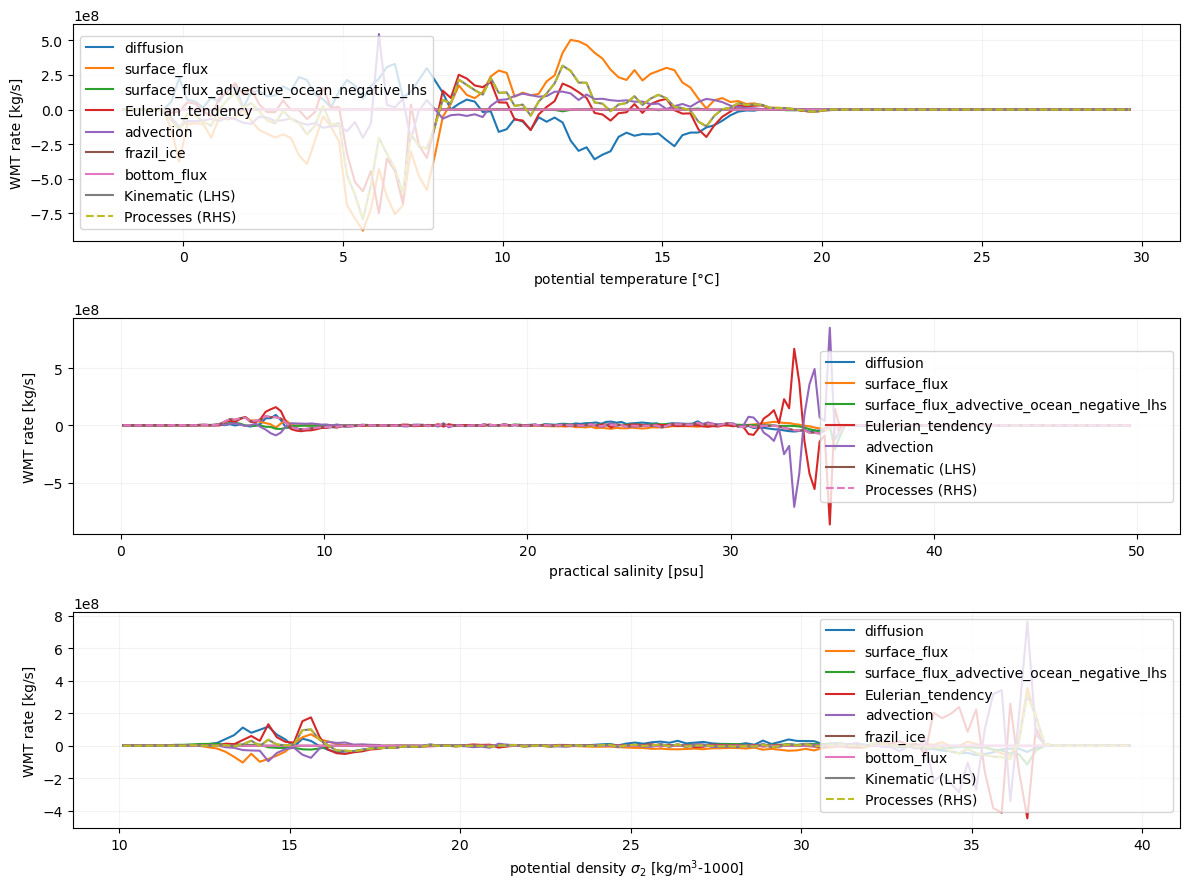

In [11]:
long_names =  [r"potential temperature [$\degree$C]", r"practical salinity [psu]", r"potential density $\sigma_{2}$ [kg/m$^{3}$-1000]"]

plt.figure(figsize=(12, 9))
for i, (G, long_name) in enumerate(zip([G_temperature, G_salinity, G_density], long_names)):
    plt.subplot(3,1,i+1)
    for v in wmt.available_processes():
        if v not in G: continue
        G[v].plot(label=v)
    G['kinematic_material_derivative'].plot(label="Kinematic (LHS)")
    G['process_material_derivative'].plot(label="Processes (RHS)", ls="--")
    plt.legend()
    plt.ylabel("WMT rate [kg/s]")
    plt.xlabel(long_name)
    plt.grid(True, alpha=0.15)
plt.tight_layout()

In density coordinates, there seems to be a dominant balance between diffusion and surface fluxes. Let's break those processes down even further to gain a better understanding.

In [12]:
decomposed_budgets = xbudget.aggregate(budgets_dict, decompose=["diffusion", "surface_flux", "nonadvective_exchange"])
wmt = xwmt.WaterMassTransformations(grid, decomposed_budgets)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    G_density = wmt.integrate_transformations(
        "sigma2",
        bins=np.arange(10, 40, 0.25),
        **kwargs
    ).mean('time')

In [13]:
decomposed_budgets

{'mass': {'lambda': 'density',
  'thickness': 'thkcello',
  'lhs': {'Eulerian_tendency': 'mass_lhs_Eulerian_tendency_product'},
  'rhs': {'advection': 'mass_rhs_advection_sum',
   'surface_flux_rain_and_ice': 'prlq',
   'surface_flux_snow': 'prsn',
   'surface_flux_evaporation': 'evs',
   'surface_flux_rivers': 'friver',
   'surface_flux_icebergs': 'ficeberg',
   'surface_flux_virtual_precip_restoring': 'vprec'}},
 'heat': {'lambda': 'thetao',
  'surface_lambda': 'tos',
  'lhs': {'Eulerian_tendency': 'opottemptend',
   'advection': 'heat_lhs_advection_product',
   'surface_flux_advective_ocean_negative_lhs': 'heat_lhs_surface_flux_advective_ocean_negative_lhs_product'},
  'rhs': {'diffusion_horizontal': 'opottemppmdiff',
   'diffusion_vertical': 'opottempdiff',
   'surface_flux_nonadvective_exchange_latent': 'hflso',
   'surface_flux_nonadvective_exchange_sensible': 'hfsso',
   'surface_flux_nonadvective_exchange_longwave': 'rlntds',
   'surface_flux_nonadvective_exchange_shortwave': '

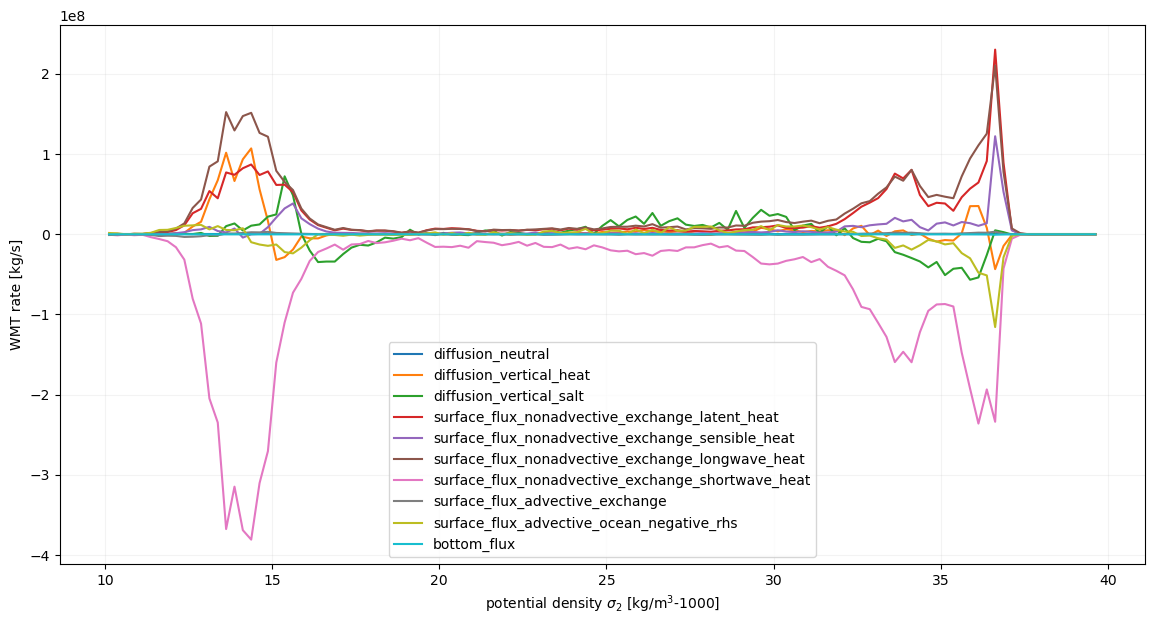

In [14]:
G = G_density
long_name = r"potential density $\sigma_{2}$ [kg/m$^{3}$-1000]"

processes = [
    "diffusion_neutral",
    "diffusion_vertical_heat",
    "diffusion_vertical_salt",
    "surface_flux_nonadvective_exchange_latent_heat",
    "surface_flux_nonadvective_exchange_sensible_heat",
    "surface_flux_nonadvective_exchange_longwave_heat",
    "surface_flux_nonadvective_exchange_shortwave_heat",
    "surface_flux_advective_exchange",
    "surface_flux_advective_ocean_negative_rhs",
    "frazil_heat_tendency",
    "bottom_flux",
]

plt.figure(figsize=(14, 7))
for v in processes:
    if v not in G: continue
    G[v].plot(label=v)
plt.legend()
plt.ylabel("WMT rate [kg/s]")
plt.xlabel(long_name)
plt.grid(True, alpha=0.15)